# Solving Partial Differential Equation Problem with PINN

In this tutorial, I will be solve partial differential equation problem with ANN.

### 2D Poisson Equation

$$
\frac{∂^2u(x, y)}{∂x^2}+\frac{∂^2u(x, y)}{∂y^2}=e^{-x}(x-2+y^{3}+6y)
$$

with $(x, y) \in [0, 1]$, and boundary condition defined as:
$$
u(x, 0)=xe^{-x} \\
u(x, 1)=(x+1)e^{-x} \\
u(0, y)=y^3 \\
u(1, y)=(1+y^3)e^{-1}
$$

The analytical solution is:
$$
u(x, y) = (x+y^3)e^{-x}
$$

In [1]:
import numpy as np
from pyDOE import lhs

# Data size on the solution
nx, ny = (100, 100)   # means that in the domain there are 10.000 data points
x = np.linspace(0, 1, nx) # the x and y values are between 0 to 1 with 100 points each
x = np.reshape(x, (-1, 1))
y = np.linspace(0, 1, ny)
y = np.reshape(y, (-1, 1))

xv, yv = np.meshgrid(x, y)

exact_u = (xv+yv**3)*np.exp(-xv)

# Preparing the x and y together as an input for predictions in one single array, as x_star
x_star = np.hstack((xv.flatten()[:, None], yv.flatten()[:, None]))
x_star.shape

# Preparing the exact solution in similar position correspond with each combination input x and y
u_star = exact_u.flatten()[:, None]

# Determine how much points for training in both boundary condition and PDE itself
N_b = 50
N_u = 5000

# Preparing the idx to take points as a training from the boundary condition
idx = np.random.choice(x_star.shape[0], N_b, replace=False) # Here we take random number between 0 to 150 for index in the boundary
x_b_train = x_star[idx, :] # training data from boundary condition
b_train = u_star[idx, :] # exact solution from boundary condition

# Bounday condition and exact value when u(x, 0) (bottom)
xx1 = np.hstack((xv[0:1, :].T, yv[0:1, :].T))
uu1 = exact_u[0:1, :].T

# Bounday condition and exact value when u(x, 1) (top)
xx2 = np.hstack((xv[0:1, :].T, yv[-1:, :].T))
uu2 = exact_u[-1:, :].T

# Bounday condition and exact value when u(0, y) (left)
xx3 = np.hstack((xv[:, 0:1], yv[:, 0:1]))
uu3 = exact_u[:, 0:1]

# Bounday condition and exact value when u(1, y) (right)
xx4 = np.hstack((xv[:, -1:], yv[:, -1:]))
uu4 = exact_u[:, -1:]

# Stacking all boundary condition the exact value in single variable
x_b_train = np.vstack([xx1, xx2, xx3, xx4])
b_train = np.vstack([uu1, uu2, uu3, uu4])

# We are not taking all points in the boundary for training, we only take 150 based on N_b instead
idx = np.random.choice(x_b_train.shape[0], N_b, replace=False)
# Getting the corresponding x_b_train (which is now scarce boundary/initial coordinates)
x_b_train = x_b_train[idx, :]
# Getting the corresponding b_train
b_train = b_train[idx, :]

# Domain bounds (lowerbounds upperbounds) [x, t], which are here ([0, 0]) and ([1, 1])
lb = x_star.min(axis=0)
ub = x_star.max(axis=0)

# Preparing the training data inside PDE domain
x_u_train = lb + (ub-lb)*lhs(2, N_u)

# Dummy exact value
idx = np.random.choice(x_u_train.shape[0], N_u, replace=False)
u_train = u_star[idx, :]

In [3]:
import tensorflow as tf

def u_model():
    x_f = tf.convert_to_tensor(x_u_train[:, 0:1], dtype=tf.float32)
    y_f = tf.convert_to_tensor(x_u_train[:, 1:2], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        tape.watch(y_f)
        with tf.GradientTape(persistent=True) as gtape:
            gtape.watch(x_f)
            gtape.watch(y_f)
            input = tf.stack([x_f[:, 0], y_f[:, 0]], axis=1)
            u = model_nn(input)
        u_x = gtape.gradient(u, x_f)
        u_y = gtape.gradient(u, y_f)
        del gtape
    u_xx = tape.gradient(u_x, x_f)
    u_yy = tape.gradient(u_y, y_f)
    del tape

    fx = tf.math.exp(-x_f)*(x_f-2.0+y_f**3.0+6.0*y_f)

    return u_xx + u_yy - fx

def __loss(x_u_train, u_train):
    x_b = tf.convert_to_tensor(x_b_train, dtype=tf.float32)
    b_f = tf.convert_to_tensor(b_train, dtype=tf.float32)

    b_pred = model_nn(x_b)
    u_pred = u_model()

    loss_b = tf.reduce_mean(tf.square(b_f - b_pred))
    loss_u = tf.reduce_mean(tf.square(u_pred))

    return loss_b + loss_u

In [4]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model_nn = Sequential([Dense(50, activation="tanh", kernel_initializer='normal', input_shape=x_u_train.shape[1:]),
                       Dense(50, kernel_initializer='normal', activation='tanh'),
                       Dense(50, kernel_initializer='normal', activation='tanh'),
                       Dense(1, kernel_initializer='normal')])

opt = keras.optimizers.Adam(learning_rate = 0.001)
model_nn.compile(loss=__loss, optimizer=opt)

In [5]:
import time

start = time.perf_counter()

model_nn.compile(loss=__loss, optimizer=opt)
history = model_nn.fit(x_u_train, u_train, epochs = 100, verbose=1, validation_split=0.15)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
133/133 [==============================] - 10s 63ms/step - loss: 2.9231 - val_loss: 2.6405
Epoch 2/100
133/133 [==============================] - 8s 60ms/step - loss: 1.4052 - val_loss: 0.6256
Epoch 3/100
133/133 [==============================] - 8s 58ms/step - loss: 0.3163 - val_loss: 0.1639
Epoch 4/100
133/133 [==============================] - 8s 59ms/step - loss: 0.1539 - val_loss: 0.1492
Epoch 5/100
133/133 [==============================] - 8s 58ms/step - loss: 0.1458 - val_loss: 0.1423
Epoch 6/100
133/133 [==============================] - 8s 58ms/step - loss: 0.1388 - val_loss: 0.1352
Epoch 7/100
133/133 [==============================] - 8s 59ms/step - loss: 0.1317 - val_loss: 0.1280
Epoch 8/100
133/133 [==============================] - 8s 59ms/step - loss: 0.1228 - val_loss: 0.1136
Epoch 9/100
133/133 [==============================] - 8s 60ms/step - loss: 0.0779 - val_loss: 0.0389
Epoch 10/100
133/133 [==============================] - 8s 60ms/step - loss: 0.02

133/133 [==============================] - 6s 43ms/step - loss: 6.6380e-04 - val_loss: 1.4713e-04
Epoch 77/100
133/133 [==============================] - 5s 41ms/step - loss: 1.4316e-04 - val_loss: 1.4138e-04
Epoch 78/100
133/133 [==============================] - 5s 41ms/step - loss: 3.8366e-04 - val_loss: 1.7067e-04
Epoch 79/100
133/133 [==============================] - 5s 40ms/step - loss: 3.9111e-04 - val_loss: 1.4911e-04
Epoch 80/100
133/133 [==============================] - 5s 40ms/step - loss: 2.6769e-04 - val_loss: 0.0058
Epoch 81/100
133/133 [==============================] - 5s 40ms/step - loss: 3.5912e-04 - val_loss: 1.3644e-04
Epoch 82/100
133/133 [==============================] - 5s 41ms/step - loss: 4.8193e-04 - val_loss: 1.5868e-04
Epoch 83/100
133/133 [==============================] - 5s 41ms/step - loss: 1.3880e-04 - val_loss: 1.3326e-04
Epoch 84/100
133/133 [==============================] - 5s 40ms/step - loss: 5.2975e-04 - val_loss: 1.3413e-04
Epoch 85/100
133/1

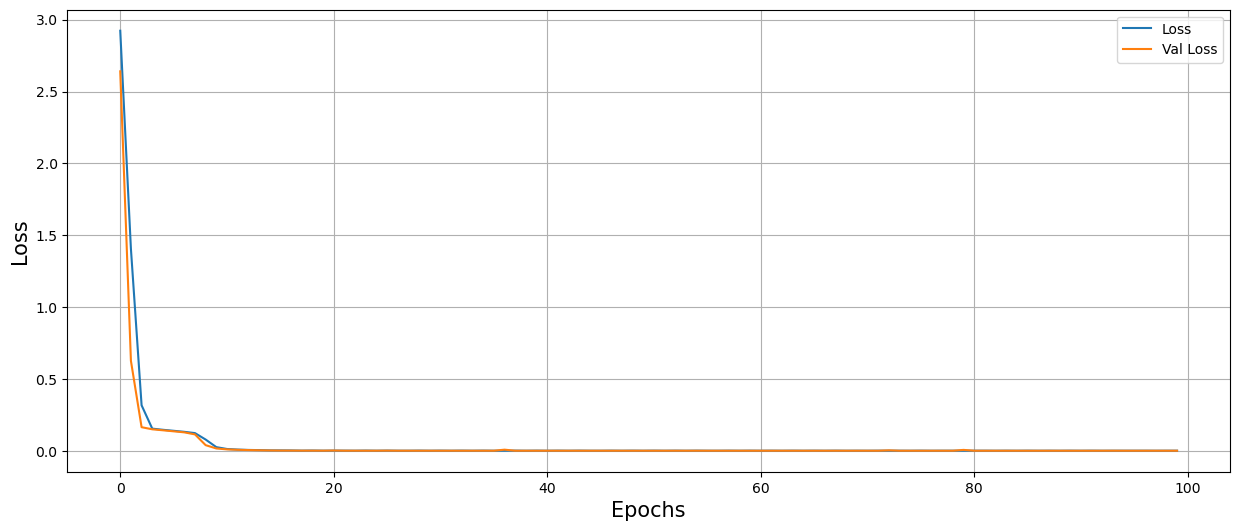

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.grid(True)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.show()

In [7]:
# Generating Predictions on testing data
Predictions = model_nn.predict(x_star)
mse_ann_test = model_nn.evaluate(x_star, u_star)
print('ANN MSE:', mse_ann_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.1475e-04
ANN MSE: 0.0001147504590335302


In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def figsize(scale, nplots=1):
    fig_width_pt = 390.0
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = nplots*fig_width*golden_mean
    fig_size = [fig_width, fig_height]
    return fig_size

def newfig(width, nplots=1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def plot_inf_cont_results(x_star, u_pred, x_b_train, b_train, exact_u, xv, yv, x, y, file=None):

    # Interpolating the results on the whole (x,t) domain.
    # griddata(points, values, points at which to interpolate, method)
    u_pred = griddata(x_star, u_pred, (xv, yv), method='cubic')

    # Creating the figures
    fig, ax = newfig(1.5, 2.5)
    ax.axis('off')

    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[y.min(), y.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(x_b_train[:,1], x_b_train[:,0], 'kx', label = 'Data (%d points)' % (b_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(y.min(), y.max(), 2)[:,None]
    ax.plot(x[40]*np.ones((2,1)), line, 'k--', linewidth = 1)

    ax.set_xlabel('$x$', fontsize = 15)
    ax.set_ylabel('$y$', fontsize = 15)
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x, y)$', fontsize = 15)
    #plt.savefig('Poisson_Adaptive_PINN_iter=100+2000.jpg')

    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(exact_u.T[40,:], y, 'b-', linewidth = 5, label = 'Exact')       
    ax.plot(u_pred.T[40,:], y, 'r--', linewidth = 5, label = 'PINN Prediction')
    ax.set_xlabel('$u(x, y)$', fontsize = 15)
    ax.set_ylabel('$y$', fontsize = 15)
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_title('$x = %.2f$' % (y[40]), fontsize = 15)
    ax.legend(loc='upper center')
    #plt.savefig('PDE6_Adaptive_PINN_GA_Approx.jpg')
    plt.show()

def plot_inf_cont_exact(x_star, exact_u, x, y, file=None):
    # Creating the figures
    fig, ax = newfig(1.5, 2.5)
    ax.axis('off')

    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(exact_u, interpolation='nearest', cmap='rainbow', 
                extent=[y.min(), y.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.set_xlabel('$x$', fontsize = 15)
    ax.set_ylabel('$y$', fontsize = 15)
    #ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x, y)$', fontsize = 15)
    #plt.savefig('PDE6_Exact_Solution.jpg')
    plt.show()

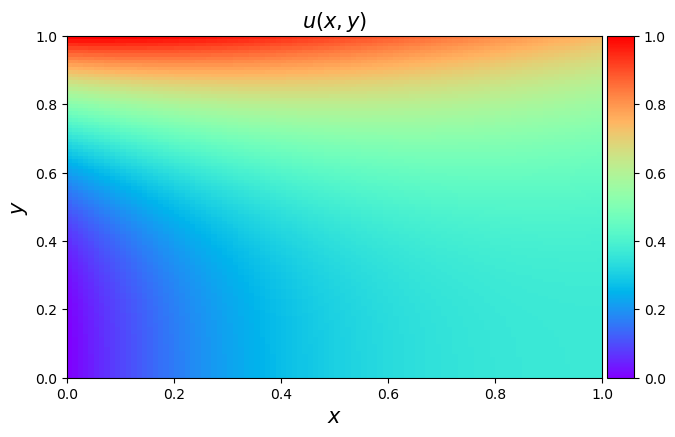

In [18]:
plot_inf_cont_exact(x_star, exact_u, x, y)

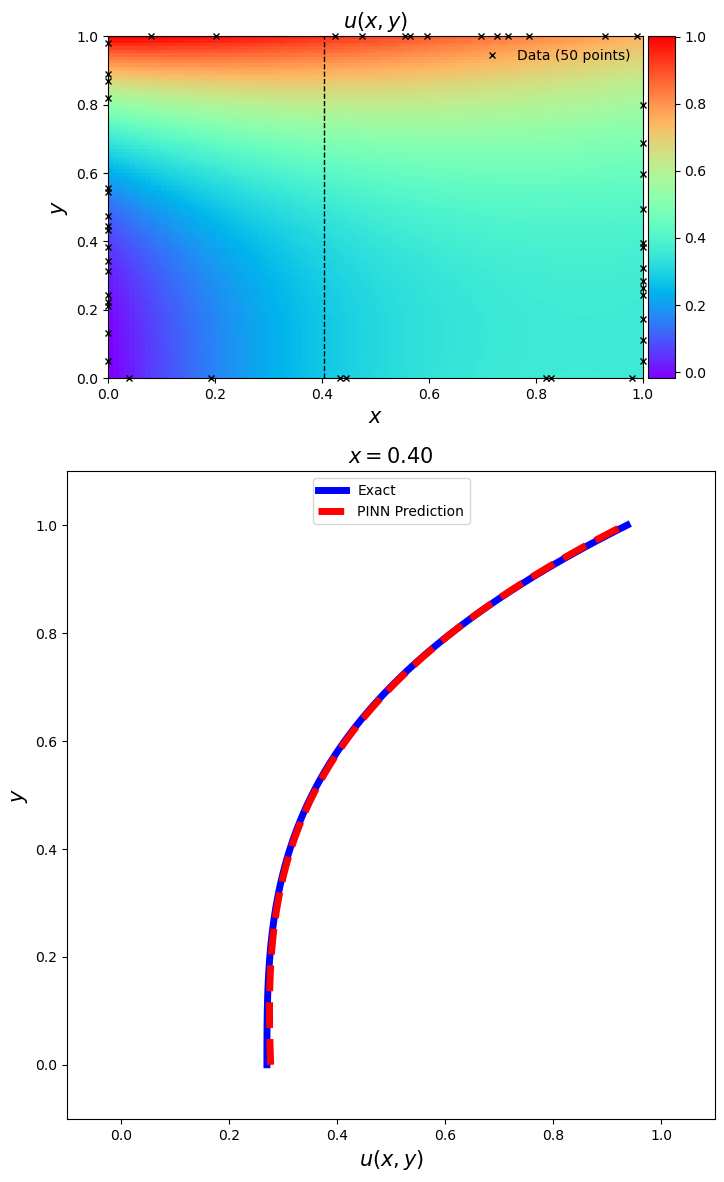

In [19]:
plot_inf_cont_results(x_star, Predictions.flatten(), x_b_train, b_train, exact_u, xv, yv, x, y)